In [1]:
%%capture
!python -m pip install datafold

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
from sklearn.metrics.pairwise import euclidean_distances
import numpy.linalg as la
from scipy.linalg import expm
from scipy.sparse import csr_matrix, diags
from sklearn.datasets import make_swiss_roll
from datafold.utils.plot import plot_pairwise_eigenvector

import datafold.dynfold as dfold

# DiffusionMap

The following function `get_eigenfunctions` performs the Diffusion Map algorithm, computing the first $n$ eigenfunctions from a dataset $X$. The `max_distance` parameter is used so that the distance matrix is sparse and only contains values before this threshold distance.

In [3]:
def get_sparse_distance_matrix(vector1, vector2, max_distance=100):
    kd_tree1 = KDTree(vector1)
    kd_tree2 = KDTree(vector2)
    return csr_matrix(kd_tree1.sparse_distance_matrix(kd_tree2, max_distance))


In [4]:
def get_eigenfunctions(X, n=0, max_distance=100):
    
    D = get_sparse_distance_matrix(X, X, max_distance)
    eps = 0.05 * D.max()
    W = np.exp(-(D.toarray() ** 2) / eps)
    P_inv = diags(1/W.sum(axis=1))
    K = P_inv @ W @ P_inv
    Q_nsroot = diags(1/np.sqrt(K.sum(axis=1)))
    T_hat = Q_nsroot @ K @ Q_nsroot

    a, v = la.eigh(T_hat)
    sorted = np.argsort(a)[::-1]

    if n==0:
        indexes = sorted
    else:
        indexes = sorted[:n]

    a = a[indexes]
    lambdas = np.sign(a) * (np.abs(a)) ** (1 / (2*eps))
    print(lambdas.shape)
    phi = Q_nsroot @ v
    phi = phi[:,indexes]
    return phi

## Part One

First, we import the data set:

In [10]:
N = 1000
X=np.zeros((N,2))
t = np.array([2*np.pi*i/(N+1) for i in range(1, N+1)])
X[::,0] = np.cos(t)
X[::,1] = np.sin(t)

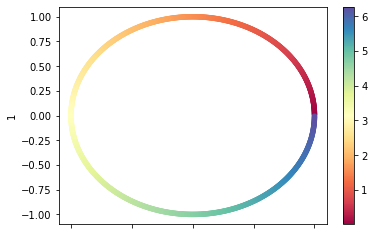

In [11]:
# A basic visualization of data
pd.DataFrame(X).plot(x=0, y=1, kind = "scatter", c=t,cmap=plt.cm.Spectral)

The first $n$ eigenvalues are:

In [12]:
eig_functions = get_eigenfunctions(X, n=5,max_distance=100)

(5,)


In [13]:
eig_functions.shape

(1000, 5)

In [14]:
dataframe = pd.DataFrame(eig_functions)
dataframe["t"] = t
dataframe.head(3)

0         1         2         3         4         t
0  0.299634  0.002692  0.423432  0.005386 -0.423107  0.006277
1  0.299634  0.005383  0.423407  0.010771 -0.423007  0.012554
2  0.299634  0.008074  0.423365  0.016153 -0.422841  0.018831

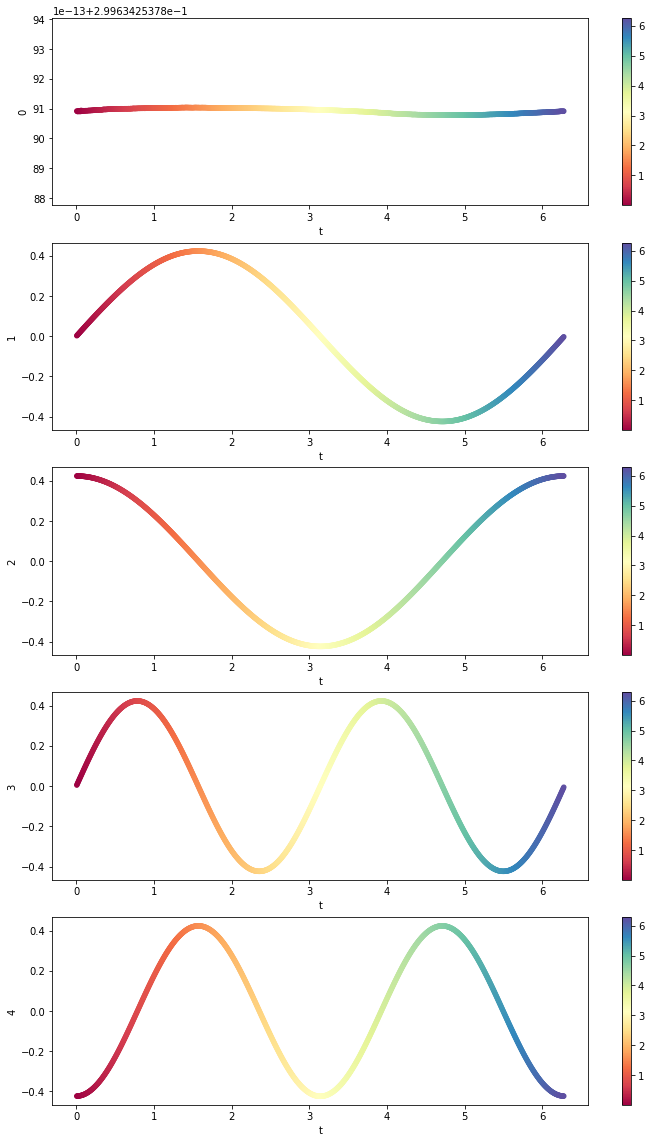

In [15]:
fig, axes = plt.subplots(ncols=1, nrows=5,figsize=(12, 20))

dataframe.plot(ax=axes[0], y=0, x="t", kind="scatter", c=t, cmap=plt.cm.Spectral)
dataframe.plot(ax=axes[1], y=1, x="t", kind="scatter", c=t, cmap=plt.cm.Spectral)
dataframe.plot(ax=axes[2], y=2, x="t", kind="scatter", c=t, cmap=plt.cm.Spectral)
dataframe.plot(ax=axes[3], y=3, x="t", kind="scatter", c=t, cmap=plt.cm.Spectral)
dataframe.plot(ax=axes[4], y=4, x="t", kind="scatter", c=t, cmap=plt.cm.Spectral)

fig.savefig('Ex3_Task2_Part1.pdf')

## Part Two

In [ ]:
nr_samples = 5000

nr_samples_plot = 5000
idx_plot = np.random.permutation(nr_samples)[0:nr_samples_plot]

# generate point cloud
X, X_color = make_swiss_roll(nr_samples, random_state=3, noise=0)

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    X[idx_plot, 0],
    X[idx_plot, 1],
    X[idx_plot, 2],
    c=X_color[idx_plot],
    cmap=plt.cm.Spectral,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("point cloud on SwissRoll manifold")
ax.view_init(10, 70)

fig.savefig('Ex3_Task2_Part2_SwissRoll_5000.pdf')

In [ ]:
%%time
eig_functions = get_eigenfunctions(X, n=10, max_distance=100)

In [ ]:
eig_functions.shape

(5000, 10)

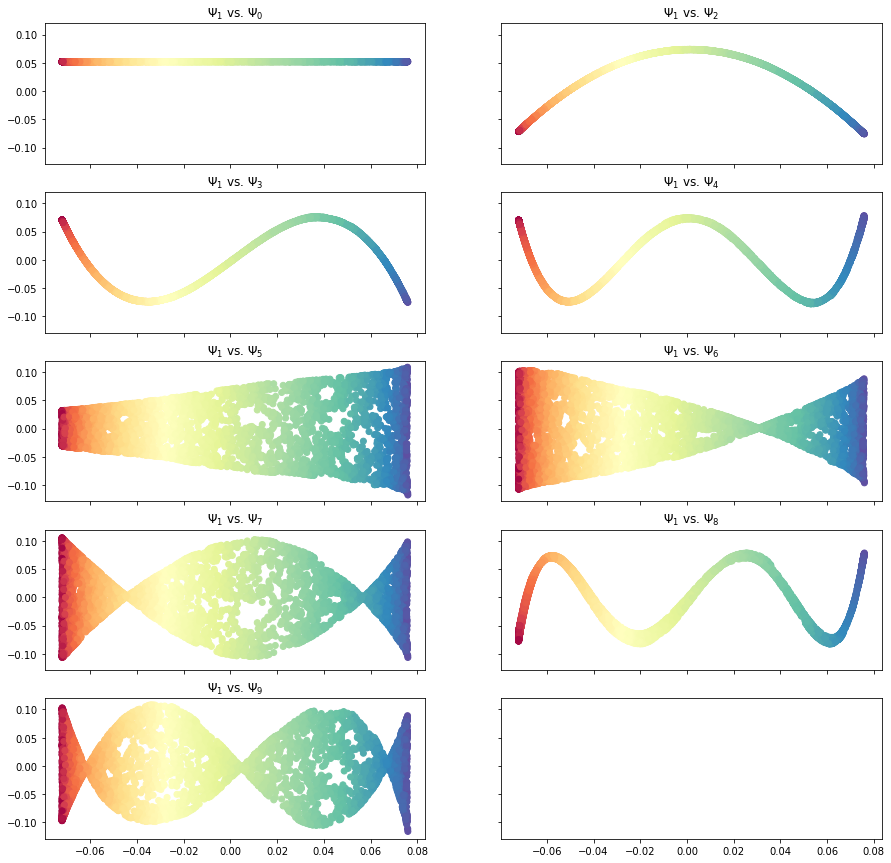

In [ ]:
plot_pairwise_eigenvector(
    eigenvectors=eig_functions,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(cmap=plt.cm.Spectral, c=X_color))
plt.savefig('Ex3_Task2_Part2_Eigenfunctions_5000.pdf')

### Applying PCA to the Swiss Roll

In [ ]:
def center_data(uncentered: np.ndarray) -> np.ndarray:
    """Centers a dataset, i.e. each component is substracted the mean
       of the column.

    Args:
        uncentered (np.ndarray): data to be centered
    """
    centered = np.zeros(uncentered.shape)
    mean = uncentered.mean(axis=0) # computes mean of every column (component)
    for i in range(centered.shape[1]):
        centered[:, i] = uncentered[:, i] - mean[i]
    return centered, mean

def decompose_svd(x: np.ndarray):
    """Performs principal value decomposition of a matrix X.
       Returns matrices U, S, V such that X = USV^T

    Args:
        x (np.ndarray): matrix X
    """

    u, sigma, vt = np.linalg.svd(x)
    v = vt.T  # because np.linalg.svd returns V^T, not V
    s = np.zeros(x.shape)  # S might not be square!
    # construct S from sigma
    for i in range(len(sigma)):
        s[i, i] = sigma[i]

    return u, s, v

centered_data, mean_data = center_data(X) 
u, s, v = decompose_svd(centered_data)
sigma = np.diag(s)  # vector of singular values
print(f'singular values:\n{sigma}')
print(f'principal components:\n', v)

singular values:
[506.57823167 452.28614727 427.62385257]
principal components:
 [[ 0.47282996 -0.87799162  0.07458252]
 [-0.05057136 -0.11154175 -0.99247215]
 [ 0.87970129  0.46549883 -0.09714151]]


In [ ]:
def get_energies(singular_values: np.ndarray) -> np.ndarray:
    """returns an energy matrix, i.e. a diagonal matrix where the i-th element
    is the variance explained by the i-th principal component.
       
    Args:
        singular_values: vector containing all singular values, i.e.
        the diagonal part of S where S comes from the SVD X = USV^T.
    """
    sv = np.diag(singular_values)  # square, diagonal matrix
    energy = sv**2 / np.trace(sv @ sv)  
    return energy  

energy = get_energies(np.diag(s))
print(f'energies:\n{energy}')

energies:
[[0.39845187 0.         0.        ]
 [0.         0.31762114 0.        ]
 [0.         0.         0.28392699]]


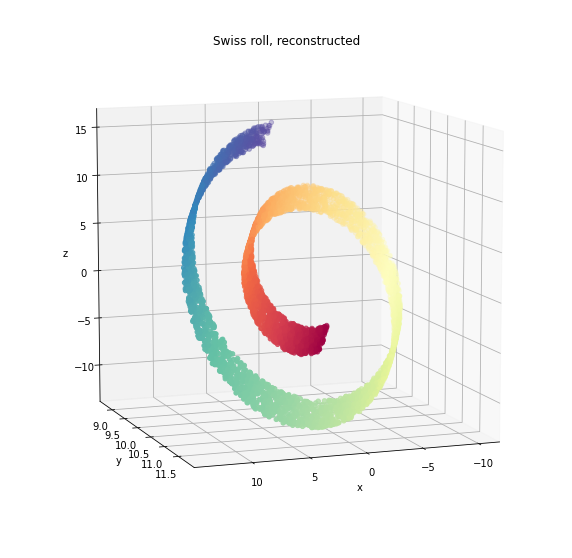

In [ ]:
def reconstruct(u: np.ndarray, s: np.ndarray, v: np.ndarray, 
                r: int) -> np.ndarray:
    """Reconstructs (reduces) a dataset with a reduced number of 
       principal components. 

    Args:
        r (int): number of leading principal components to consider 
        s, u, v (np.ndarray): matrices from the singular value decomposition
            of the dataset
    """
    
    threshold = np.sort(np.diag(s))[-r] # r-th largest value
    s_reduced = np.copy(s)
    print()
    for i in range(len(np.diag(s))):
        if s_reduced[i, i] < threshold:
            s_reduced[i, i] = 0
    data_reduced = u @ s_reduced @ v.T
    return data_reduced

centered_data_reduced = reconstruct(u, s, v, r=2)

def uncenter_data(centered: np.ndarray, mean: np.ndarray) -> np.ndarray:
    """Un-centers a dataset, i.e. each component is substracted the mean
       of the column.

    Args:
        centered (np.ndarray): data to be un-centered
        mean (np.ndarray): vector where the i-th component is the mean
                           of the i-th column
    """

    uncentered = np.zeros(centered.shape)
    for i in range(centered.shape[1]):
        uncentered[:, i] = centered[:, i] + mean[i]
    return uncentered

reconstructed_data = uncenter_data(centered_data_reduced, mean_data)

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    reconstructed_data[idx_plot, 0],
    reconstructed_data[idx_plot, 1],
    reconstructed_data[idx_plot, 2],
    c=X_color[idx_plot],
    cmap=plt.cm.Spectral,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Swiss roll, reconstructed")
ax.view_init(10, 70)

fig.savefig('Ex3_Task2_Part2_SwissRoll_Reconstructed.pdf')

## Part Three: applying Diffusion Maps to the dataset in Task 1

(9,)


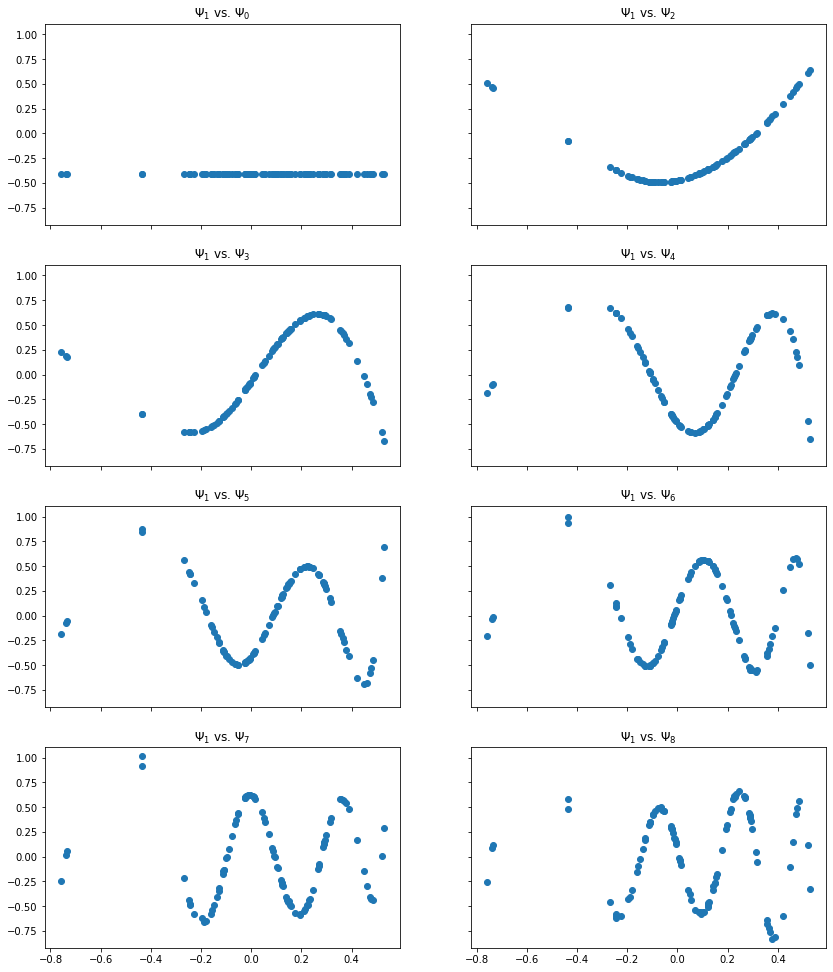

In [ ]:
raw_data = np.loadtxt('sample_data/pca_dataset.txt')
centered_data, _ = center_data(raw_data)
eig_functions_3 = get_eigenfunctions(centered_data, n=9, max_distance=10)

plot_pairwise_eigenvector(
    eigenvectors=eig_functions_3,
    n=1,
    fig_params=dict(figsize=[14, 17]),
    scatter_params=dict(cmap=plt.cm.Spectral))

plt.savefig('Ex3_Task2_Part3.pdf')

Only one eigenfunction $\phi_1$ is enough to represent most of the data, because there is a relation between every eigenfunction and $\phi_1$.